In [ ]:
# import gym
import numpy as np
from typing import Optional
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import random
import gymnasium as gym
from gymnasium import spaces
import numpy as np

In [ ]:
class PreyPredatorEnv(gym.Env):
    def __init__(self):
        super(PreyPredatorEnv, self).__init__()
        self.grid_size = 5
        self.action_space = spaces.Discrete(4)  # 4 possible actions: up, down, left, right
        self.observation_space = spaces.Box(low=0, high=self.grid_size-1, shape=(4,), dtype=np.int32)
        self.reset()

    def reset(self):
        # Predator starts at random position
        self.predator_pos = np.random.randint(0, self.grid_size, size=(2,))
        # Prey starts at a fixed position
        self.prey_pos = np.random.randint(0, self.grid_size, size=(2,))
        return np.concatenate([self.predator_pos, self.prey_pos])

    def step(self, predator_action, prey_action):
        # Move the predator based on the action
        if predator_action == 0:  # up
            self.predator_pos[0] = max(self.predator_pos[0] - 1, 0)
        elif predator_action == 1:  # down
            self.predator_pos[0] = min(self.predator_pos[0] + 1, self.grid_size - 1)
        elif predator_action == 2:  # left
            self.predator_pos[1] = max(self.predator_pos[1] - 1, 0)
        elif predator_action == 3:  # right
            self.predator_pos[1] = min(self.predator_pos[1] + 1, self.grid_size - 1)

        # Prey random movement
        if prey_action == 0:  # up
            self.prey_pos[0] = max(self.prey_pos[0] - 1, 0)
        elif prey_action == 1:  # down
            self.prey_pos[0] = min(self.prey_pos[0] + 1, self.grid_size - 1)
        elif prey_action == 2:  # left
            self.prey_pos[1] = max(self.prey_pos[1] - 1, 0)
        elif prey_action == 3:  # right
            self.prey_pos[1] = min(self.prey_pos[1] + 1, self.grid_size - 1)

        # Check if the predator caught the prey
        done = np.array_equal(self.predator_pos, self.prey_pos)
        predator_reward = 1 if done else -0.1  # Reward for catching the prey, penalty otherwise
        prey_reward = -1 if done else 0
    
        
        return np.concatenate([self.predator_pos, self.prey_pos]), predator_reward, prey_reward, done, {}
        
    

    # def render(self):
    #     grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
    #     grid[:, :] = '-'
    #     grid[self.prey_pos[0], self.prey_pos[1]] = 'P'
    #     grid[self.predator_pos[0], self.predator_pos[1]] = 'A'
    #     print("\n".join([" ".join(row) for row in grid]))
    #     print()
    
    def render(self, mode='human', return_env=False):
        fig, ax = plt.subplots()
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks(np.arange(0, self.grid_size, 1))
        ax.set_yticks(np.arange(0, self.grid_size, 1))
        ax.grid(True)

        # Add prey
        prey_patch = patches.Rectangle(self.prey_pos[::-1], 1, 1, edgecolor='green', facecolor='green', label="Prey")
        ax.add_patch(prey_patch)

        # Add predator
        predator_patch = patches.Rectangle(self.predator_pos[::-1], 1, 1, edgecolor='red', facecolor='red', label="Predator")
        ax.add_patch(predator_patch)

        plt.legend(handles=[prey_patch, predator_patch])
        plt.title('Predator-Prey Grid World')
        plt.pause(0.3)  # Pause to visualize each step
        plt.show()
        
        if return_env:
            return fig, ax

    def close(self):
        pass

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Neural Network for the Q-value function
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class Agent:
    def __init__(self, env):
        self.env = env
        self.q_network = DQN(input_dim=4, output_dim=env.action_space.n)
        self.target_network = DQN(input_dim=4, output_dim=env.action_space.n)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()

        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.batch_size = 64
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.q_network(state)
                return q_values.argmax().item()

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def update_q_network(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(np.array(actions))
        rewards = torch.FloatTensor(np.array(rewards))
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(np.array(dones))

        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(next_states).max(1)[0]
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = self.loss_fn(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

c:\Users\adits\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Episode 1, Total Reward for Predator: -0.30000000000000004, Total Reward for Prey: -1, Steps: 14
Episode 2, Total Reward for Predator: 0.6, Total Reward for Prey: -1, Steps: 5
Episode 3, Total Reward for Predator: -2.0000000000000013, Total Reward for Prey: -1, Steps: 31
Episode 4, Total Reward for Predator: 0.30000000000000004, Total Reward for Prey: -1, Steps: 8
Episode 5, Total Reward for Predator: 0.5, Total Reward for Prey: -1, Steps: 6
Episode 6, Total Reward for Predator: 0.10000000000000009, Total Reward for Prey: -1, Steps: 10
Episode 7, Total Reward for Predator: 0.30000000000000004, Total Reward for Prey: -1, Steps: 8
Episode 8, Total Reward for Predator: -2.0000000000000013, Total Reward for Prey: -1, Steps: 31
Episode 9, Total Reward for Predator: 0.7, Total Reward for Prey: -1, Steps: 4
Episode 10, Total Reward for Predator: 0.9, Total Reward for Prey: -1, Steps: 2
Episode 11, Total Reward for Predator: -4.899999999999995, Total Reward for Prey: -1, Steps: 60
Episode 12, 

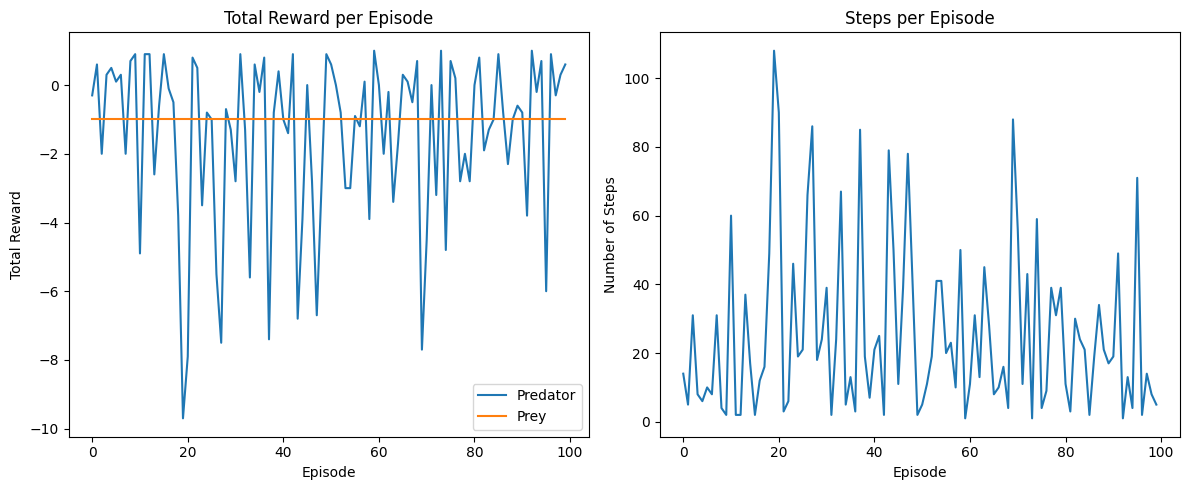

In [4]:


# Training loop
# env = PreyPredatorEnv()
# agent = Agent(env)
# num_episodes = 500

# for episode in range(num_episodes):
#     state = env.reset()
#     total_reward = 0
#     done = False

#     while not done:
#         action = agent.select_action(state)
#         next_state, reward, done, _ = env.step(action)
#         agent.store_transition(state, action, reward, next_state, done)
#         agent.update_q_network()
#         state = next_state
#         total_reward += reward

#     agent.update_target_network()

#     if agent.epsilon > agent.epsilon_min:
#         agent.epsilon *= agent.epsilon_decay

#     print(f"Episode {episode + 1}, Total Reward: {total_reward}")

# env.close()

import torch
import random

# # Training loop
# env = PreyPredatorEnv()
# agent = Agent(env)
# num_episodes = 500

# for episode in range(num_episodes):
#     state = env.reset()
#     total_reward = 0
#     done = False

#     while not done:
#         action = agent.select_action(state)
#         next_state, reward, done, _ = env.step(action)
#         agent.store_transition(state, action, reward, next_state, done)
#         agent.update_q_network()
#         state = next_state
#         total_reward += reward

#     agent.update_target_network()

#     if agent.epsilon > agent.epsilon_min:
#         agent.epsilon *= agent.epsilon_decay

#     print(f"Episode {episode + 1}, Total Reward: {total_reward}")

# Training loop
env = PreyPredatorEnv()
predator = Agent(env)
prey = Agent(env)
num_episodes = 100

predator_rewards_per_episode = []
prey_rewards_per_episode = []
steps_per_episode = []

for episode in range(num_episodes):
    state = env.reset()
    predator_total_reward = 0
    prey_total_reward = 0
    steps = 0
    done = False

    while steps < 500 and not done:
        predator_action = predator.select_action(state)
        prey_action = prey.select_action(state)
        next_state, predator_reward, prey_reward, done, _ = env.step(predator_action, prey_action)
        predator.store_transition(state, predator_action, predator_reward, next_state, done)
        prey.store_transition(state, prey_action, prey_reward, next_state, done)
        predator.update_q_network()
        prey.update_q_network()
        state = next_state
        predator_total_reward += predator_reward
        prey_total_reward += prey_reward
        steps += 1

    predator.update_target_network()
    prey.update_target_network()

    if predator.epsilon > predator.epsilon_min:
        predator.epsilon *= predator.epsilon_decay
    
    if prey.epsilon > prey.epsilon_min:
        prey.epsilon *= prey.epsilon_decay

    predator_rewards_per_episode.append(predator_total_reward)
    prey_rewards_per_episode.append(prey_total_reward)
    steps_per_episode.append(steps)

    print(f"Episode {episode + 1}, Total Reward for Predator: {predator_total_reward}, Total Reward for Prey: {prey_total_reward}, Steps: {steps}")

# Plot the learning process
plt.figure(figsize=(12, 5))

# Plot total reward per episode for predator
plt.subplot(1, 2, 1)
plt.plot(predator_rewards_per_episode, label='Predator')
plt.plot(prey_rewards_per_episode, label='Prey')
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()

# Plot number of steps per episode
plt.subplot(1, 2, 2)
plt.plot(steps_per_episode)
plt.title('Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')

plt.tight_layout()
plt.show()


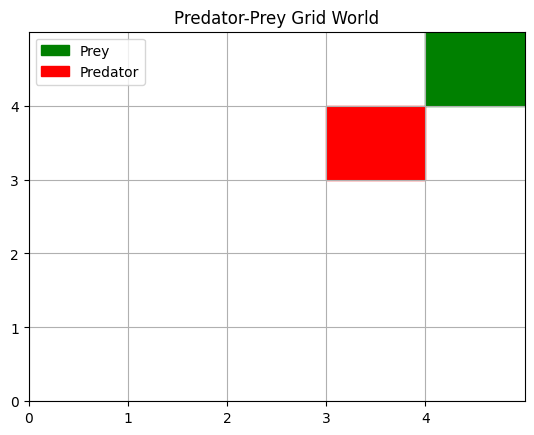

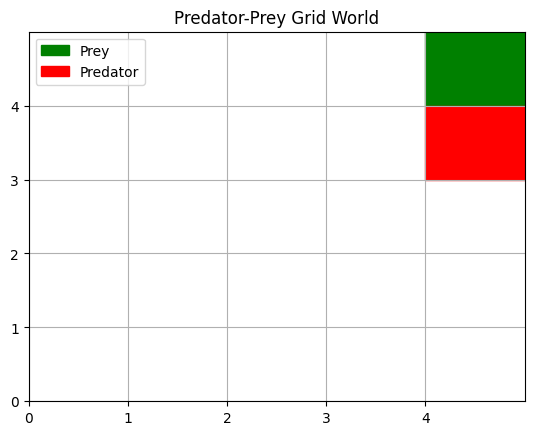

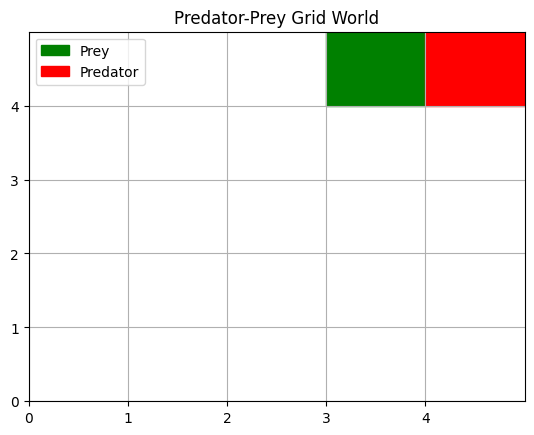

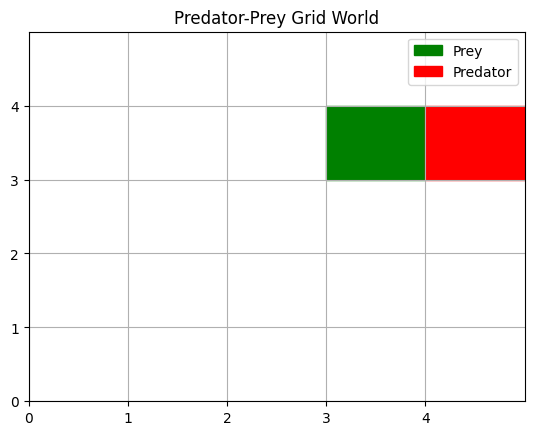

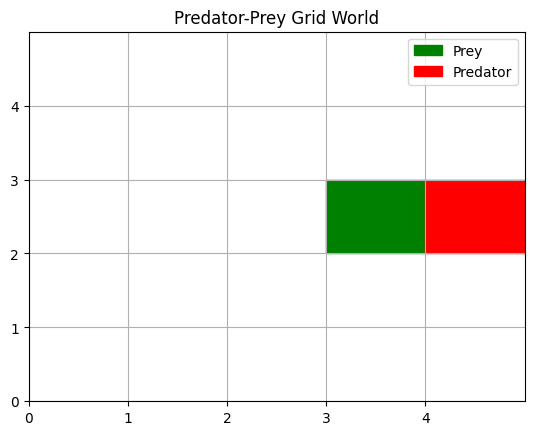

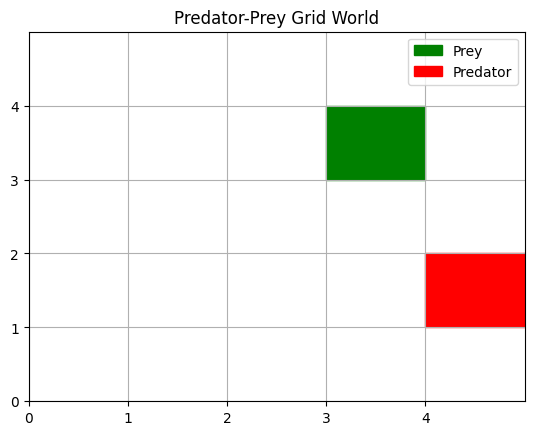

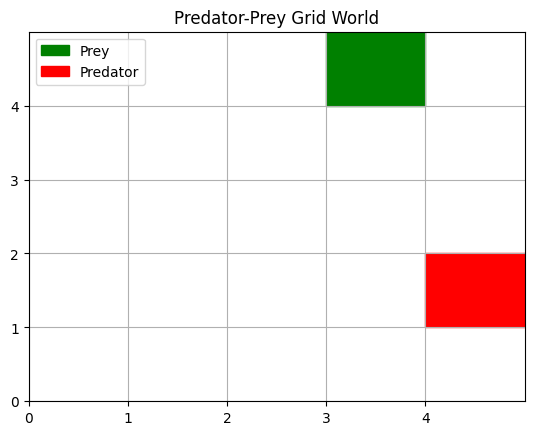

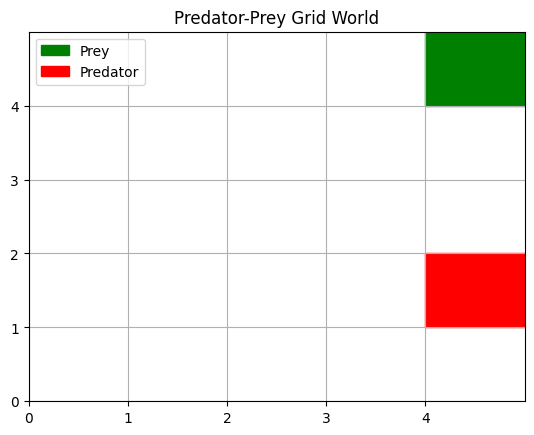

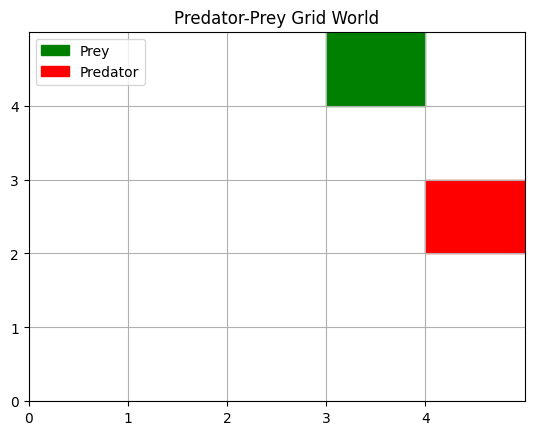

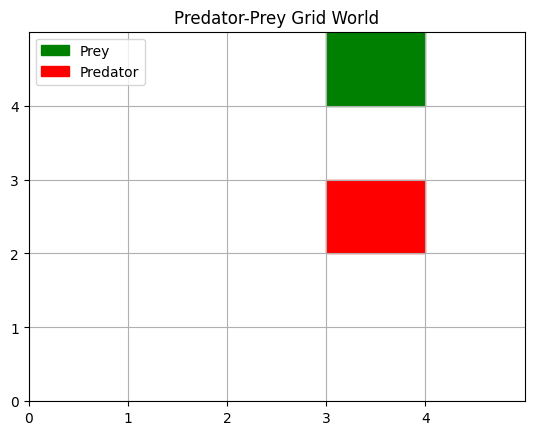

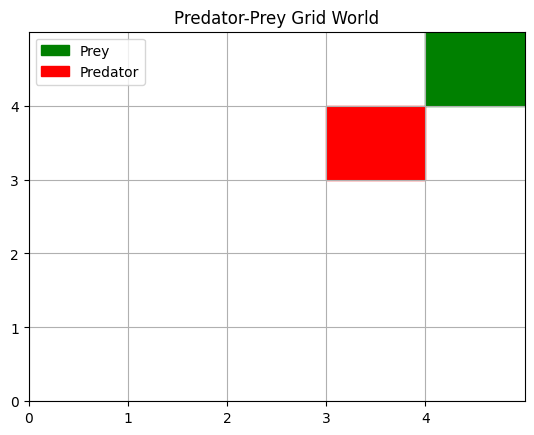

In [ ]:
# import cv2


# # Visualize the strategy learned by the agent in a test run
# state = env.reset()
# done = False
# s = 0
# while s < 10 and not done:
#     # env.render()  # Render each step
#     # print(type(env.render()))
#     s += 1
#     x, _ = env.render(return_env=True)
        
#     predator_action = predator.select_action(state)  # Use the learned policy
#     prey_action = prey.select_action(state)
#     state, predator_reward, prey_reward, done, _ = env.step(predator_action, prey_action)
# env.render()  # Render the final state
# env.close()